## **0. Tải bộ dữ liệu**
**Lưu ý:** Nếu không thể tải bằng gdown do bị giới hạn số lượt tải, các bạn hãy tải thủ công và đưa lên drive của mình, sau đó copy từ drive vào colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1F6kUoxIeDbc_oQO2ADtyIetzQkRdIc0r/view?usp=share_link
!gdown --id 1F6kUoxIeDbc_oQO2ADtyIetzQkRdIc0r

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1F6kUoxIeDbc_oQO2ADtyIetzQkRdIc0r
To: /content/weather_forecast.zip
100% 2.34M/2.34M [00:00<00:00, 237MB/s]


In [ ]:
!unzip './weather_forecast.zip'

Archive:  ./weather_forecast.zip
  inflating: weatherHistory.csv      


## **1. Import các thư viện cần thiết**

In [ ]:
import os   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split

RANDOM_SEED = 1
tf.random.set_seed(RANDOM_SEED)

## **2. Chuẩn bị dữ liệu**

In [ ]:
dataset_filepath = './weatherHistory.csv' # Khai báo đường dẫn đến file .csv của bộ dữ liệu
df = pd.read_csv(dataset_filepath) # Đọc file .csv thành DataFrame
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [ ]:
# Khai báo hàm Windowing (dùng để tạo các cặp X, y cho time series data)
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features = [] # Khai báo list dùng để lưu trữ các X
    labels = [] # Khai báo list dùng để lưu trữ các y

    window_size = input_size + offset # Tính kích thước của window

    # Nếu df_end_idx = chỉ mục cuối cùng bảng dữ liệu, cần phải dời xuống 1 khoảng = window size 
    if df_end_idx == None:
        df_end_idx = len(df) - window_size 
    
    # Duyệt qua từng mẫu dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size # Tính chỉ mục kết thúc của X
        label_start_idx = idx + window_size - label_size # Tính chỉ mục bắt đầu của y

        feature = df[idx:feature_end_idx] # Lấy X
        label = df[label_start_idx:(idx+window_size)] # Lấy y

        features.append(feature) 
        labels.append(label)

    # Chuyển list thành np.ndarrray
    features = np.expand_dims(np.array(features), -1) 
    labels = np.array(labels)

    return features, labels

In [ ]:
# Loại bỏ các cột dữ liệu không cần thiết
univariate_df = df['Temperature (C)'] # Lấy cột nhiệt độ 
univariate_df.index = df['Formatted Date'] # Chọn cột thời gian làm chỉ mục
univariate_df

Formatted Date
2006-04-01 00:00:00.000 +0200     9.472222
2006-04-01 01:00:00.000 +0200     9.355556
2006-04-01 02:00:00.000 +0200     9.377778
2006-04-01 03:00:00.000 +0200     8.288889
2006-04-01 04:00:00.000 +0200     8.755556
                                   ...    
2016-09-09 19:00:00.000 +0200    26.016667
2016-09-09 20:00:00.000 +0200    24.583333
2016-09-09 21:00:00.000 +0200    22.038889
2016-09-09 22:00:00.000 +0200    21.522222
2016-09-09 23:00:00.000 +0200    20.438889
Name: Temperature (C), Length: 96453, dtype: float64

In [ ]:
univariate_df.head(7)

Formatted Date
2006-04-01 00:00:00.000 +0200    9.472222
2006-04-01 01:00:00.000 +0200    9.355556
2006-04-01 02:00:00.000 +0200    9.377778
2006-04-01 03:00:00.000 +0200    8.288889
2006-04-01 04:00:00.000 +0200    8.755556
2006-04-01 05:00:00.000 +0200    9.222222
2006-04-01 06:00:00.000 +0200    7.733333
Name: Temperature (C), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fddecaafbb0>],
      dtype=object)

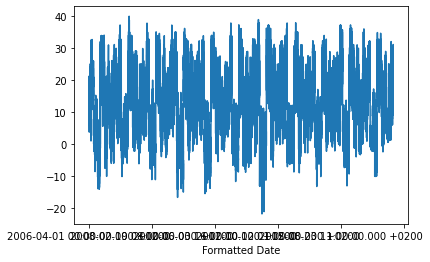

In [ ]:
univariate_df.plot(subplots=True)

In [ ]:
INPUT_SIZE = 6 # Dùng `input_size` giờ trước
LABEL_SIZE = 1 # Để dự đoán nhiệt độ trong `label_size` giờ
OFFSET = 1 # Vào khoảng `offset` giờ tiếp theo 
BATCH_SIZE = 32

In [ ]:
dataset_length = len(univariate_df) # Số lượng mẫu dữ liệu trong DataFrame
TRAIN_SIZE = 0.7 # Tỉ lệ kích thước tập train
VAL_SIZE = 0.2 # Tỉ lệ kích thước tập val
# Đổi tỉ lệ thành chỉ mục
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length) 
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

# Khởi tạo X, y cho tập train
X_train, y_train = slicing_window(univariate_df, 
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

# Khởi tạo X, y cho tập val
X_val, y_val = slicing_window(univariate_df, 
                                  df_start_idx=TRAIN_END_IDX,
                                  df_end_idx=VAL_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

# Khởi tạo X, y cho tập test
X_test, y_test = slicing_window(univariate_df, 
                                  df_start_idx=VAL_END_IDX,
                                  df_end_idx=None,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET)

In [ ]:
# Khởi tạo tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [ ]:
# Cấu hình các tham số tối ưu cho việc đọc dữ liệu
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Xây dựng mô hình**

In [ ]:
# Khai báo normalization layer
normalize_layer = tf.keras.layers.Normalization(axis=-1)
normalize_layer.adapt(np.vstack((X_train, X_val, X_test)))

In [ ]:
# Xây dựng hàm khởi tạo model
def build_model(input_shape):
    model = tf.keras.Sequential([
        # Input layer (nhận vào 1 string)
        tf.keras.Input(shape=input_shape, name='input_layer'), 

        normalize_layer,

        # LSTM Layer 1 
        tf.keras.layers.LSTM(6, 
                            return_sequences=True, 
                            kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                            name='lstm_layer_1'),      

        # LSTM Layer 2
        tf.keras.layers.LSTM(6, 
                            return_sequences=True, 
                            kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                            name='lstm_layer_2'),               
                    
        # LSTM Layer 3
        tf.keras.layers.LSTM(6, 
                            return_sequences=False, 
                            kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                            name='lstm_layer_3'),      
                                
        # Output Layer
        tf.keras.layers.Dense(1, 
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer') 
    ],
    name='lstm_model')

    return model

In [ ]:
INPUT_SHAPE = X_train.shape[-2:] 
model = build_model(INPUT_SHAPE)
model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6, 1)             3         
 n)                                                              
                                                                 
 lstm_layer_1 (LSTM)         (None, 6, 6)              192       
                                                                 
 lstm_layer_2 (LSTM)         (None, 6, 6)              312       
                                                                 
 lstm_layer_3 (LSTM)         (None, 6)                 312       
                                                                 
 output_layer (Dense)        (None, 1)                 7         
                                                                 
Total params: 826
Trainable params: 823
Non-trainable params: 3
__________________________________________________________

## **4. Cấu hình mô hình**

In [ ]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 20
LR = 1e-3

In [ ]:
# Cấu hình một số thông tin cho mô hình
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), # Sử dụng optimizer Adam
    loss=tf.keras.losses.MeanSquaredError(), # Sử dụng hàm loss Mean Squared Error
)

## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/20
2110/2110 [==============================] - 24s 7ms/step - loss: 99.7706 - val_loss: 39.8270
Epoch 2/20
2110/2110 [==============================] - 14s 7ms/step - loss: 28.8962 - val_loss: 11.8286
Epoch 3/20
2110/2110 [==============================] - 14s 7ms/step - loss: 10.4886 - val_loss: 4.9368
Epoch 4/20
2110/2110 [==============================] - 16s 7ms/step - loss: 5.0292 - val_loss: 2.8844
Epoch 5/20
2110/2110 [==============================] - 15s 7ms/step - loss: 3.2606 - val_loss: 2.1593
Epoch 6/20
2110/2110 [==============================] - 15s 7ms/step - loss: 2.6771 - val_loss: 1.9312
Epoch 7/20
2110/2110 [==============================] - 15s 7ms/step - loss: 2.4661 - val_loss: 1.7777
Epoch 8/20
2110/2110 [==============================] - 14s 7ms/step - loss: 2.3716 - val_loss: 1.6675
Epoch 9/20
2110/2110 [==============================] - 14s 7ms/step - loss: 2.3183 - val_loss: 1.5970
Epoch 10/20
2110/2110 [==============================] - 15s 7ms/ste

## **6. Đánh giá và trực quan hóa**

In [ ]:
# Đánh giá mô hình trên tập test
test_evaluation = model.evaluate(test_ds)

302/302 [==============================] - 1s 3ms/step - loss: 1.2189


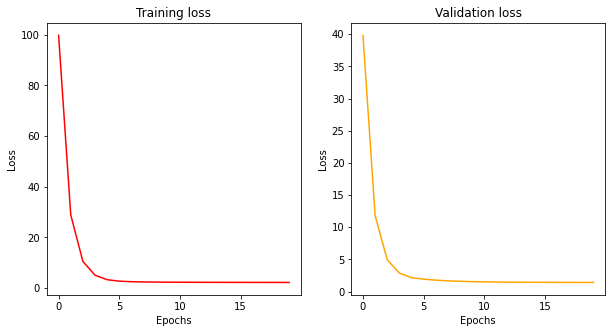

In [ ]:
train_loss = history.history['loss']# Đọc thông tin loss trên tập train
val_loss = history.history['val_loss'] # Đọc thông tin loss trên tập val

plt.figure(figsize=(10, 5)) # Cài đặt kích thước khung ảnh

plt.subplot(1, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='red') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(1, 2, 2) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='orange') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.show() # Hiển thị 2 khung ảnh nhỏ

In [ ]:
def create_time_steps(length):

  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)

  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')

  return plt

1/1 [==============================] - 1s 900ms/step


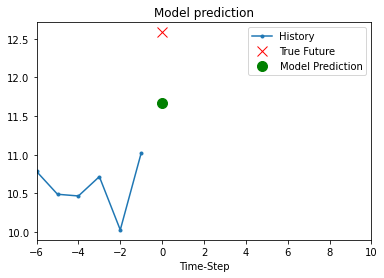

1/1 [==============================] - 0s 14ms/step


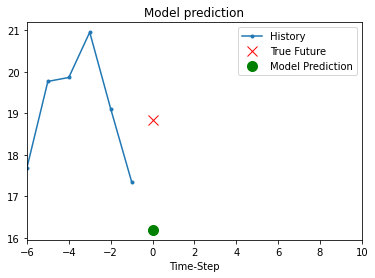

1/1 [==============================] - 0s 25ms/step


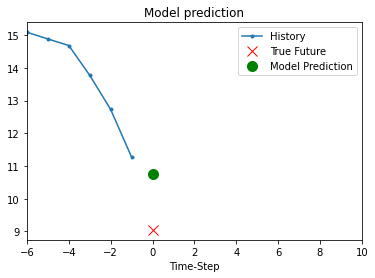

1/1 [==============================] - 0s 16ms/step


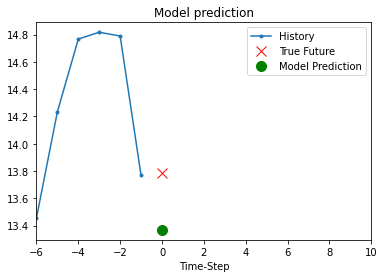

1/1 [==============================] - 0s 15ms/step


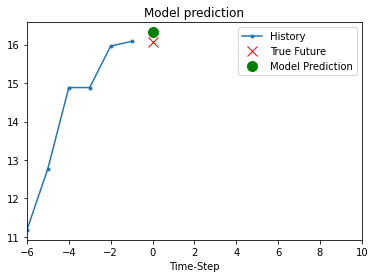

1/1 [==============================] - 0s 15ms/step


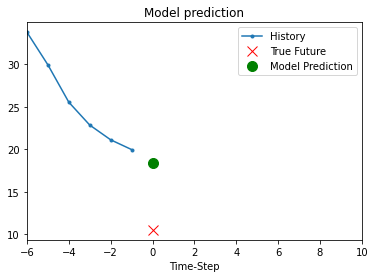

1/1 [==============================] - 0s 15ms/step


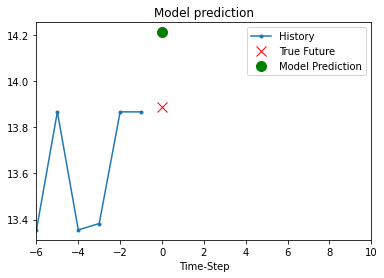

1/1 [==============================] - 0s 14ms/step


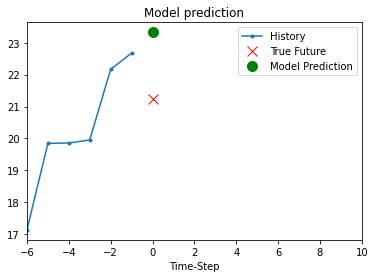

1/1 [==============================] - 0s 17ms/step


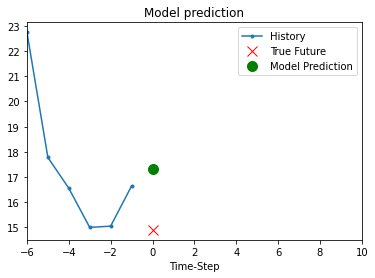

1/1 [==============================] - 0s 23ms/step


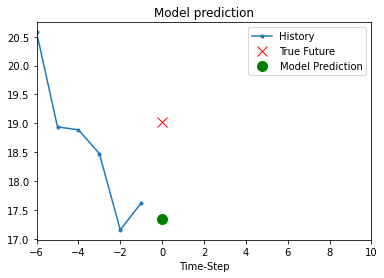

In [ ]:
for X, y in test_ds.take(10):
  plot = show_plot([X[0].numpy(), y[0].numpy(),
                    model.predict(X)[0]], 0, 'Model prediction')
  plot.show()

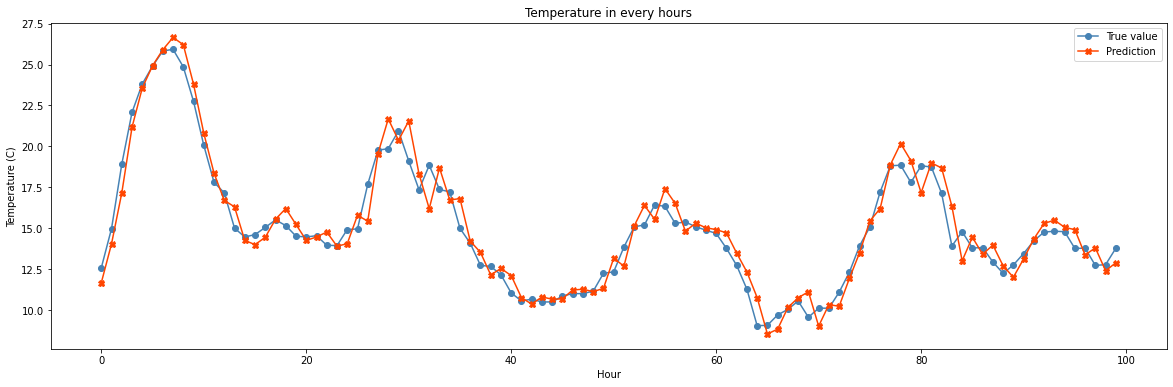

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()
    plt.show()

plot_difference(y_test[:100], model.predict(X_test[:100], verbose=0))